In [1]:
import modin.pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.pyplot import figure
import fastf1 as ff1
from fastf1 import plotting
import time
from datetime import datetime, date, time, timedelta
from timple.timedelta import strftimedelta
from fastf1.core import Laps
import matplotlib.image as image
import matplotlib.ticker as ticker
import matplotlib.patches as patches

In [2]:
#enabling the cache for the data
ff1.Cache.enable_cache('F1Cache')

#importing the data
#loading data in from session
session = ff1.get_session(2022, 'Hungarian', 'FP3')
laps = session.load_laps()
lap = laps.pick_fastest()
race=session

ver = laps.pick_driver('VER')
ham = laps.pick_driver('HAM')
gas = laps.pick_driver('GAS')
lec = laps.pick_driver('LEC')
alo = laps.pick_driver('ALO')
sai = laps.pick_driver('SAI')
oco = laps.pick_driver('OCO')
nor = laps.pick_driver('NOR')
vet = laps.pick_driver('VET')
rai = laps.pick_driver('RAI')
rus = laps.pick_driver('RUS')
tsu = laps.pick_driver('TSU')
lat = laps.pick_driver('LAT')
maz = laps.pick_driver('MAZ')
msc = laps.pick_driver('MSC')
ric = laps.pick_driver('RIC')
sto = laps.pick_driver('STR')
bot = laps.pick_driver('BOT')
per = laps.pick_driver('PER')

Use `Session.load` instead.
core           INFO 	Loading data for Hungarian Grand Prix - Practice 3 [v2.2.9]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been writt

In [3]:
laps.head(1)

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate
0,0 days 00:57:46.725000,1,NaT,1,1,0 days 00:55:44.424000,NaT,NaT,0 days 00:00:43.606000,0 days 00:00:37.218000,...,272.0,False,INTERMEDIATE,1.0,True,0 days 00:55:44.424000,Red Bull Racing,VER,1,False


In [4]:
#for loop that cleans the data because it has to run 4-5 times to normalize idk why lol
for lap in range(5):
    #turn LapTime into seconds from DD:HH:MM:SS
    laps['LapTime_seconds'] = laps['LapTime'].dt.total_seconds()

    #drop all rows with NaN in LapTime_seconds
    laps = laps.dropna(subset=['LapTime_seconds'])

    laptimemean=laps['LapTime_seconds'].mean()
    laptimestd=laps['LapTime_seconds'].std()

    #drop all rows in laps with LapTime_seconds 3 std greater than the mean lap time
    laps = laps[laps['LapTime_seconds'] < (laptimemean + 3*laptimestd)]
    

    #doing the same for Sector1Time, Sector2Time, Sector3Time
    laps['Sector1Time_seconds'] = laps['Sector1Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector1Time_seconds'])
    laps['Sector2Time_seconds'] = laps['Sector2Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector2Time_seconds'])
    laps['Sector3Time_seconds'] = laps['Sector3Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector3Time_seconds'])
    
    #finding the mean and std of the Sector times
    sector1mean=laps['Sector1Time_seconds'].mean()
    sector1std=laps['Sector1Time_seconds'].std()
    sector2mean=laps['Sector2Time_seconds'].mean()
    sector2std=laps['Sector2Time_seconds'].std()
    sector3mean=laps['Sector3Time_seconds'].mean()
    sector3std=laps['Sector3Time_seconds'].std()

    #drop all rows in laps with Sector1Time 3 std greater than the mean sector time
    laps = laps[laps['Sector1Time_seconds'] < (sector1mean + 3*sector1std)]
    #drop all rows in laps with Sector2Time 3 std greater than the mean sector time
    laps = laps[laps['Sector2Time_seconds'] < (sector2mean + 3*sector2std)]
    #drop all rows in laps with Sector3Time 3 std greater than the mean sector time
    laps = laps[laps['Sector3Time_seconds'] < (sector3mean + 3*sector3std)]

#list of drivers initials
drivers=['ver','ham','gas','lec','alo','sai','oco','nor','vet','zho','rus','tsu','lat','mag','msc','ric','sto','bot','per','alb']

In [5]:
#creating a stat deltaS1+ which is sector1mean-Sector1Time_seconds
laps['deltaS1+']=((sector1mean-laps['Sector1Time_seconds'])*100).round()#finding the delta between the mean and the sector time
#creating a stat deltaS2+ which is sector2mean-Sector2Time_seconds
laps['deltaS2+']=((sector2mean-laps['Sector2Time_seconds'])*100).round()
#creating a stat deltaS3+ which is sector3mean-Sector3Time_seconds
laps['deltaS3+']=((sector3mean-laps['Sector3Time_seconds'])*100).round()


#drop the float point from the deltaS1+ and deltaS2+ and deltaS3+
laps['deltaS1+']=laps['deltaS1+'].astype(int)
laps['deltaS2+']=laps['deltaS2+'].astype(int)
laps['deltaS3+']=laps['deltaS3+'].astype(int)

#make a new data frame called secPlus that has the drivers and the deltaS1+, deltaS2+, deltaS3+
secPlus=laps[['Driver','deltaS1+','deltaS2+','deltaS3+']]

#creating a dataframe that has the drivers and their average deltaS1+, deltaS2+, deltaS3+ scores
secPlusScores=secPlus.groupby('Driver').mean().reset_index()

#round deltaS1+,deltaS2+,deltaS3+ to the nearest integer and then remove the float point
secPlusScores['deltaS1+']=secPlusScores['deltaS1+'].round(0).astype(int)
secPlusScores['deltaS2+']=secPlusScores['deltaS2+'].round(0).astype(int)
secPlusScores['deltaS3+']=secPlusScores['deltaS3+'].round(0).astype(int)

secPlusScores.head(2)

,Driver,deltaS1+,deltaS2+,deltaS3+
0,ALB,15,-2,19
1,ALO,-16,-21,44


In [6]:
#seperate the data into the drivers and the deltaS1+, deltaS2+, deltaS3+
sector1scores=secPlusScores[['Driver','deltaS1+']].sort_values(by='deltaS1+',ascending=False)
sector2scores=secPlusScores[['Driver','deltaS2+']].sort_values(by='deltaS2+',ascending=False)
sector3scores=secPlusScores[['Driver','deltaS3+']].sort_values(by='deltaS3+',ascending=False)

#show sector1scores,sector2scores,sector3scores side by side
from IPython.display import display_html 

df1_styler = sector1scores.style.set_table_attributes("style='display:inline',").set_caption('Delta Sector1+')
df2_styler = sector2scores.style.set_table_attributes("style='display:inline'").set_caption('Delta Sector2+')
df3_styler = sector3scores.style.set_table_attributes("style='display:inline'").set_caption('Delta Sector3+')
#hide the index
df1_styler.hide_index()
df2_styler.hide_index()
df3_styler.hide_index()
display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)

Driver,deltaS1+
VER,71
LEC,68
SAI,52
RUS,39
VET,28
RIC,19
ALB,15
MAG,13
STR,9
NOR,0


 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.
 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


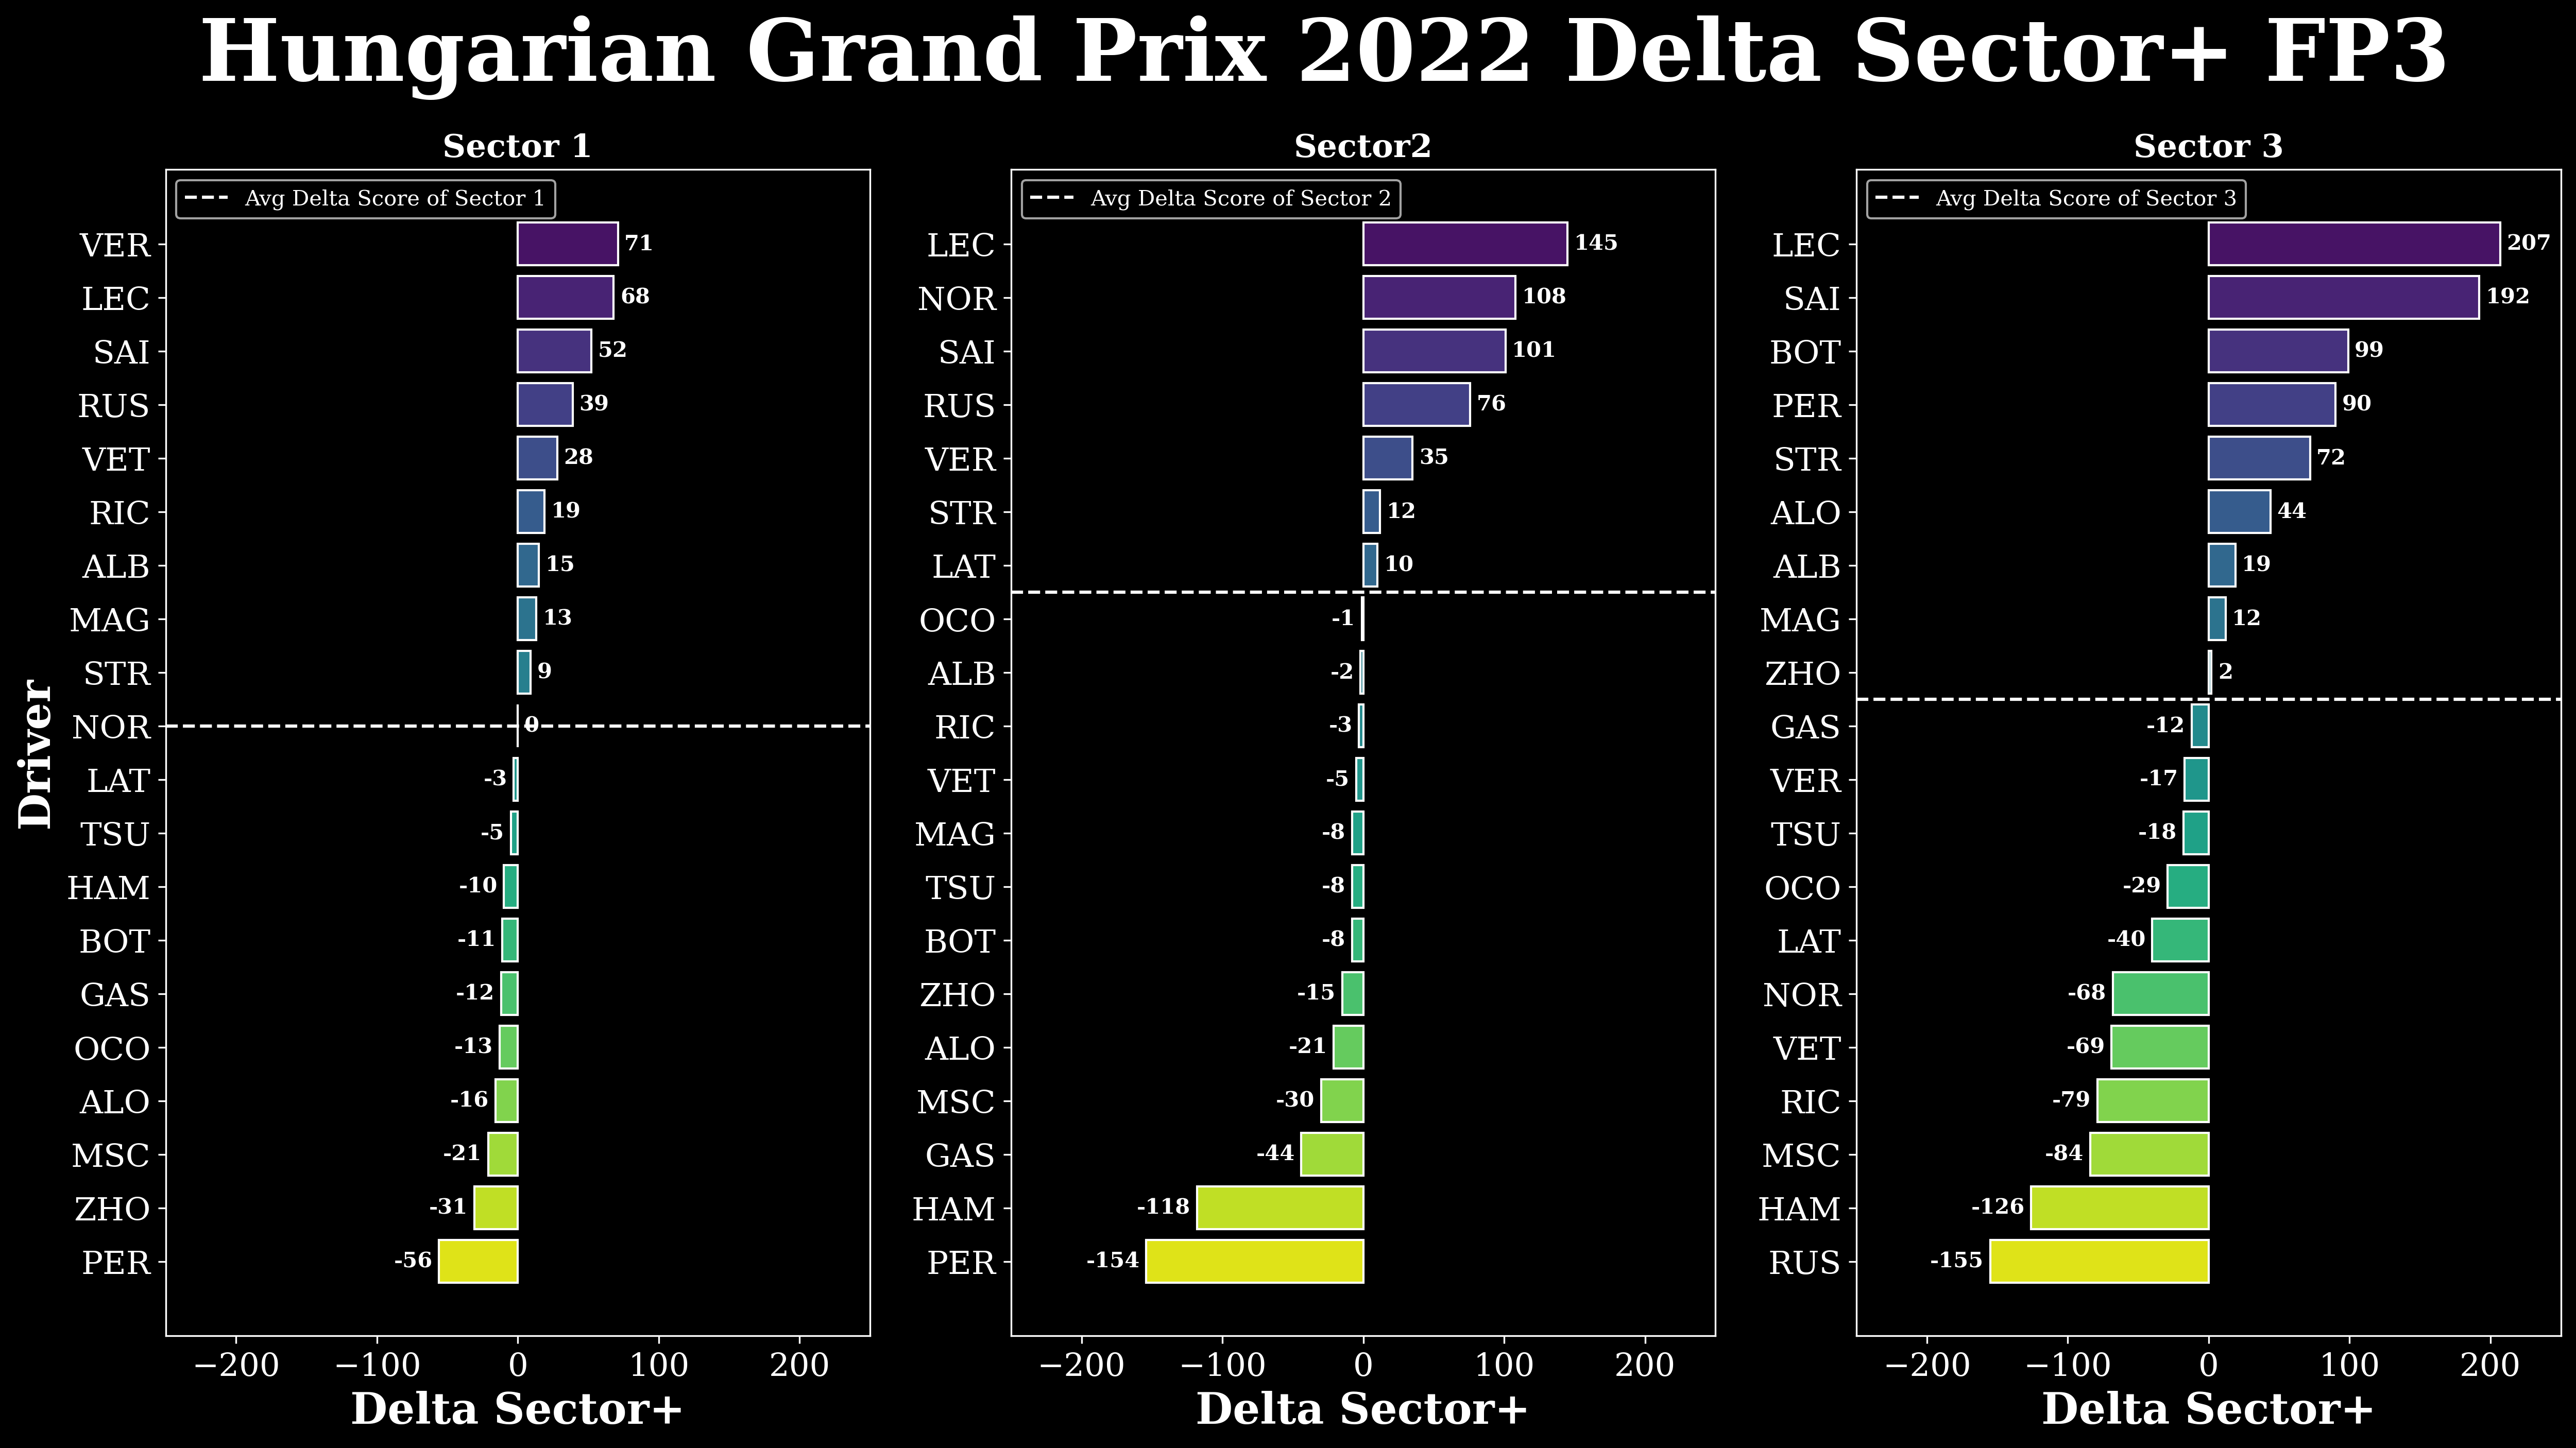

In [14]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.suptitle(f'{race.weekend.name} {race.weekend.year} Delta Sector+', fontsize=40, fontweight='bold')

#create a color palette for seaborn that goes from yellow to green to purple
colors=['#FFF817','#EDDC26','#37AB16','#69359C']

#bar plot for sector1
pd1=axs[0].barh(sector1scores['Driver'],sector1scores['deltaS1+'],edgecolor='white',color=sns.color_palette("viridis", len(sector1scores['Driver'])))
axs[0].set_title('Sector 1', fontsize=15, fontweight='bold')
axs[0].invert_yaxis()
axs[0].bar_label(pd1,padding=3,fontweight='bold')
#find where driver deltaS1+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector1scores['deltaS1+']):
    if v == 0:
        axs[0].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 1')
        break
    elif v < 0:
        axs[0].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 1')
        break
axs[0].tick_params(labelsize=15)
axs[0].set_xlim(-250,250)
axs[0].set_xlabel('Delta Sector+', fontsize=20, fontweight='bold')
axs[0].legend(loc='upper left', fontsize=10)
axs[0].set_ylabel('Driver', fontsize=20, fontweight='bold')

#bar plot for sector2
pd2=axs[1].barh(sector2scores['Driver'],sector2scores['deltaS2+'],edgecolor='white',color=sns.color_palette("viridis", len(sector2scores['Driver'])))
axs[1].set_title('Sector2', fontsize=15, fontweight='bold')
axs[1].invert_yaxis()
axs[1].bar_label(pd2,padding=3,fontweight='bold')

#find where driver deltaS2+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector2scores['deltaS2+']):
    if v == 0:
        axs[1].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 2')
        break
    elif v < 0:
        axs[1].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 2')
        break
axs[1].tick_params(labelsize=15)
axs[1].set_xlim(-250,250)
axs[1].set_xlabel('Delta Sector+',fontsize=20,fontweight='bold')
axs[1].legend(loc='upper left', fontsize=10)


#bar plot for sector3
pd3=axs[2].barh(sector3scores['Driver'],sector3scores['deltaS3+'],edgecolor='white',color=sns.color_palette("viridis", len(sector3scores['Driver'])))
axs[2].set_title('Sector 3', fontsize=15, fontweight='bold')
axs[2].invert_yaxis()
axs[2].bar_label(pd3,padding=3,fontweight='bold')

#find where driver deltaS3+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector3scores['deltaS3+']):
    if v == 0:
        axs[2].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 3')
        break
    elif v < 0:
        axs[2].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 3')
        break
axs[2].tick_params(labelsize=15)

#set the x axis ticks to -150 to 150
axs[2].set_xlim(-250,250)
axs[2].set_xlabel('Delta Sector+',fontsize=20,fontweight='bold')
axs[2].legend(loc='upper left', fontsize=10)

plt.savefig(f'F1Plots/{race.weekend.name} {race.weekend.year}DeltaSectorPlusBarChart.png')
plt.show()

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


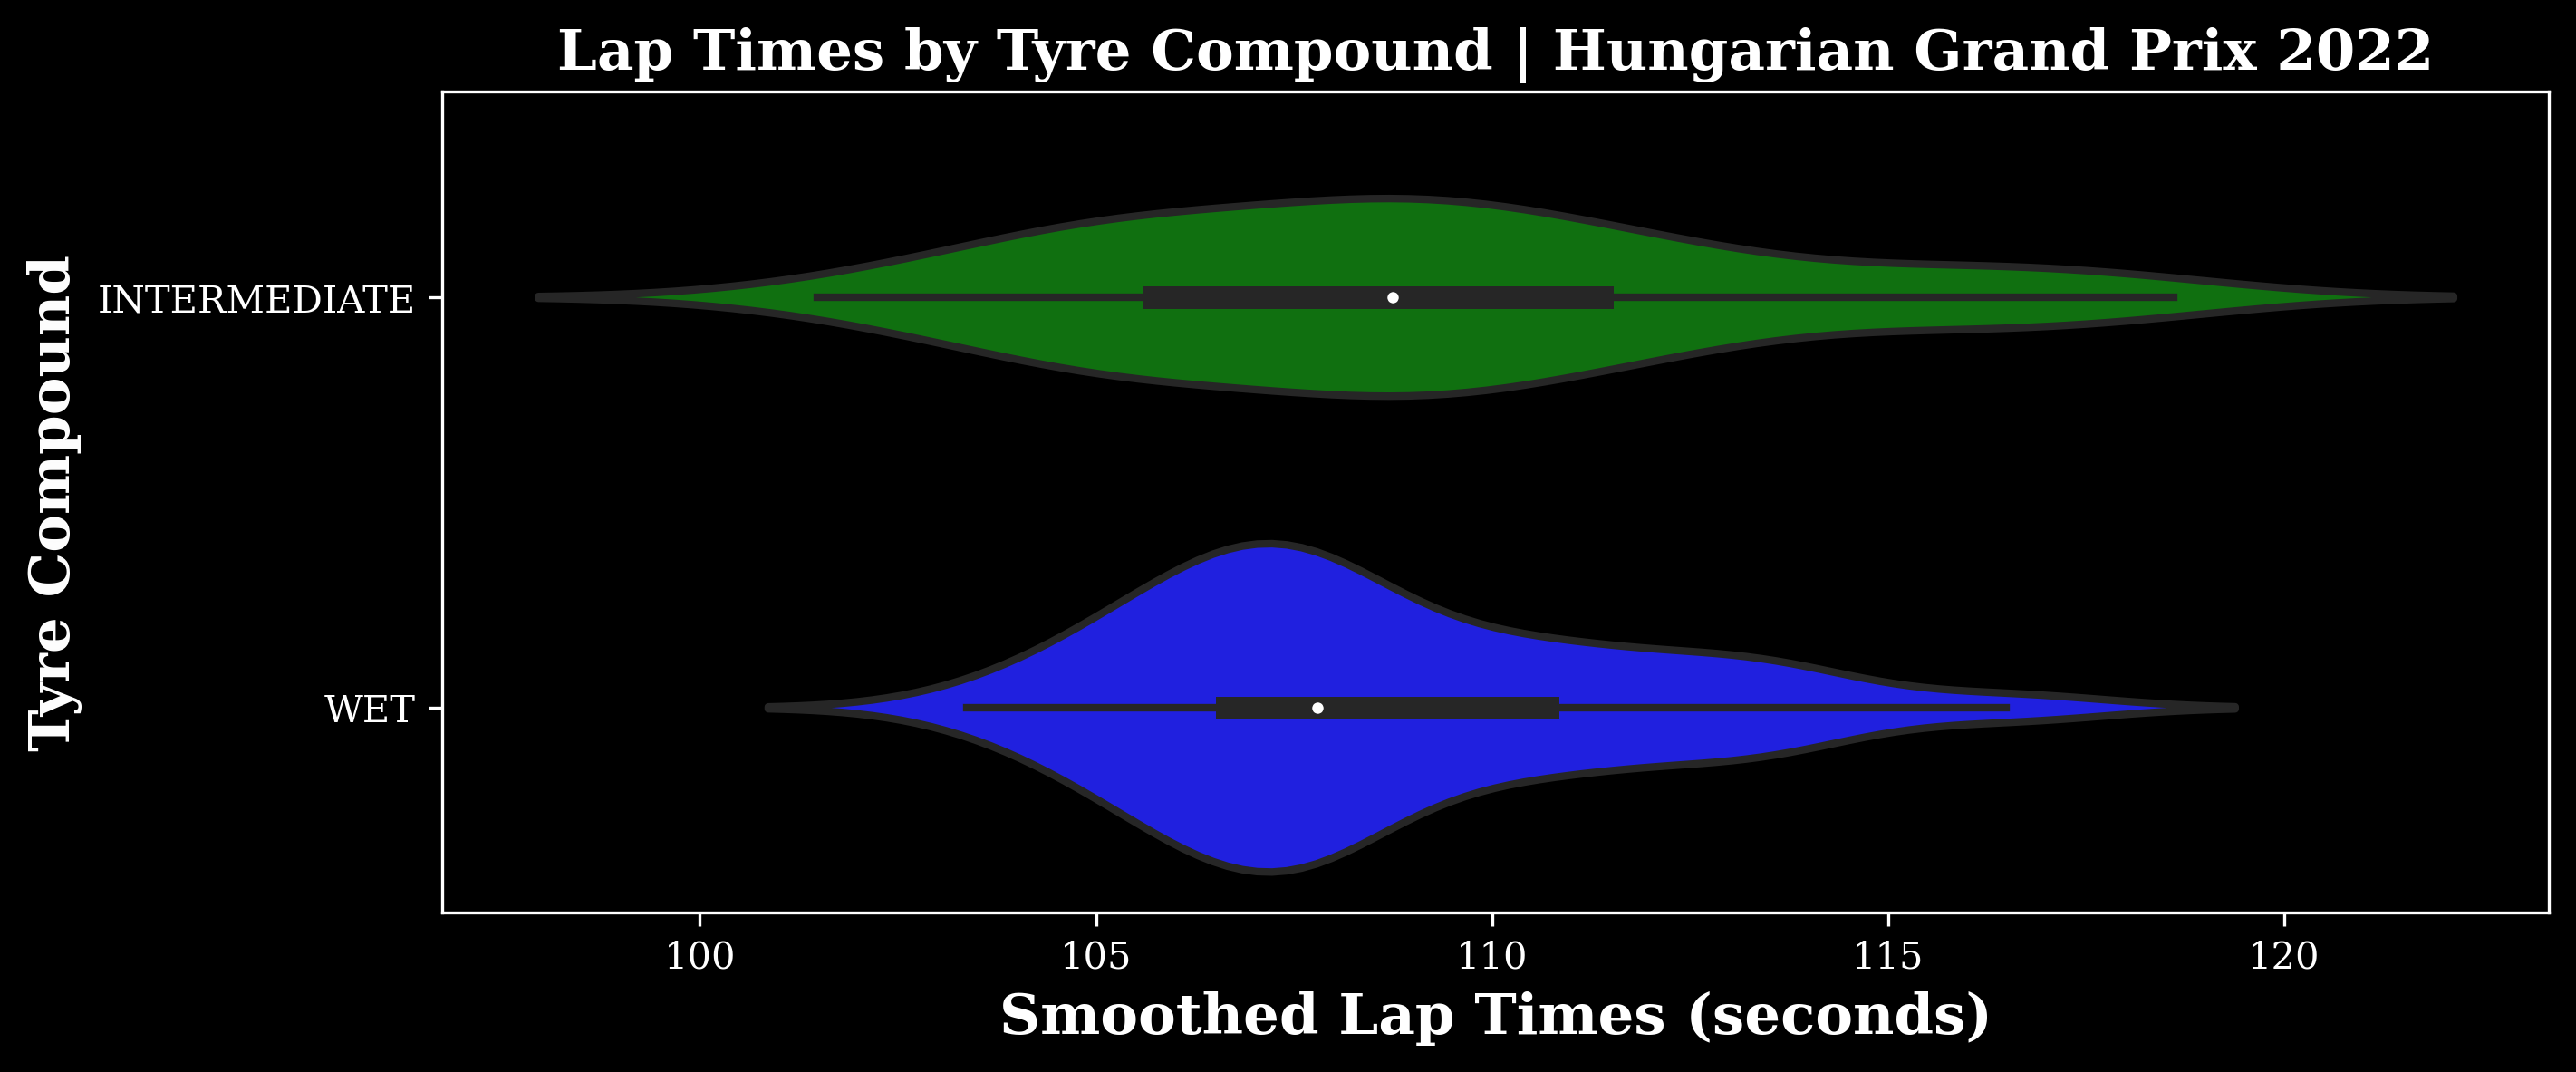

In [9]:
#violin plot showing the relationship between the lap time and the compound
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']= [10,4]
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')


#making a dictionary for colors based off of the unique tyre compound
compound_color={'SOFT':'#FF0000','MEDIUM':'#FFEF00','HARD':'#E5E4E2','INTERMEDIATE':'#008000','WET':'#0000FF','UNKNOWN':'#FF0000'}

#change UNKNOW in the laps dataframe to SOFT
laps.loc[laps['Compound']=='UNKNOWN','Compound']='SOFT'

sns.violinplot(x='LapTime_seconds', y='Compound', data=laps, palette= compound_color,linewidth=2)
plt.title(f'Lap Times by Tyre Compound | {race.weekend.name} {race.weekend.year}', fontsize=15, fontweight='bold',color='White')
plt.xlabel('Smoothed Lap Times (seconds)', fontsize=15, fontweight='bold',color='white')
plt.ylabel('Tyre Compound', fontsize=15, fontweight='bold',color='White')
plt.savefig(f'F1Plots/Lap Times by Compound {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


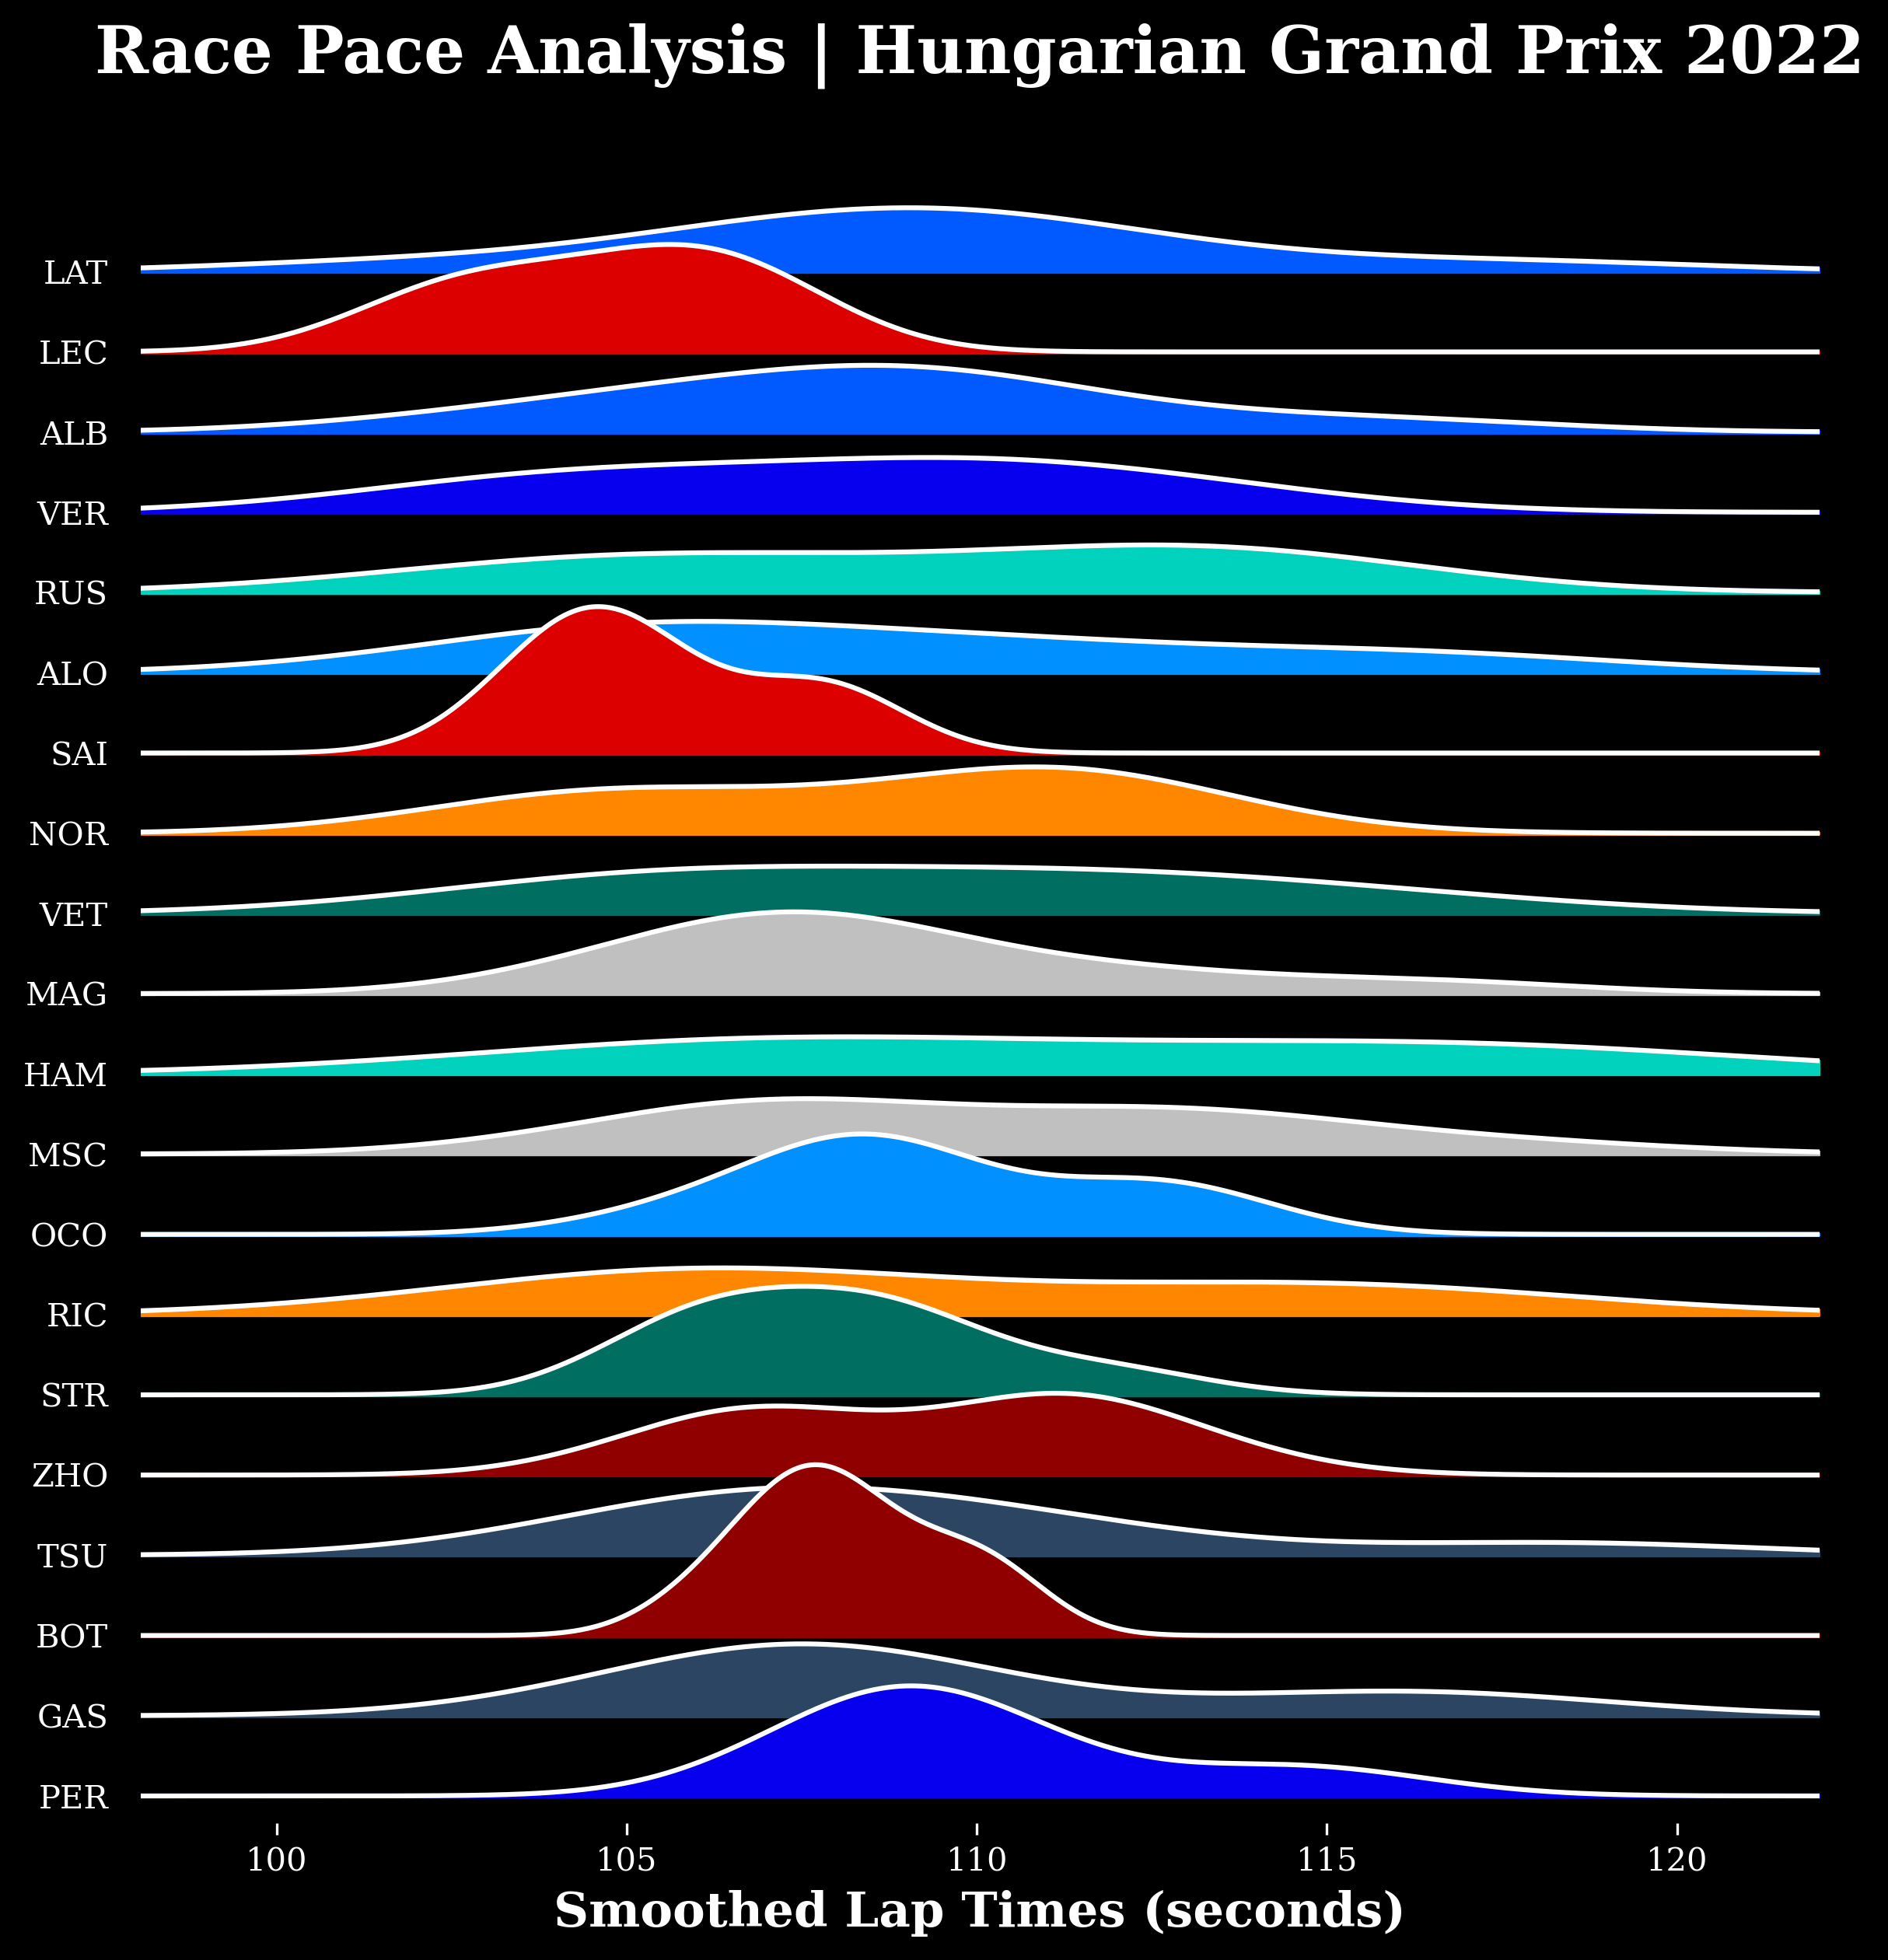

In [15]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']= [8,8]
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')

driver_color_ref=['#005aff','#0090ff','#900000','#2b4562','#00d2be','#005aff','#dc0000','silver','silver','#ff8700',
'#0090ff','#0600ef','#ff8700','#00d2be','#dc0000','#006f62','#2b4562','#0600ef','#006f62','#900000']

#setting driver names as variables to their driver color
alb_color=driver_color_ref[0]
alo_color=driver_color_ref[1]
bot_color=driver_color_ref[2]
gas_color=driver_color_ref[3]
ham_color=driver_color_ref[4]
lat_color=driver_color_ref[5]
lec_color=driver_color_ref[6]
mag_color=driver_color_ref[7]
msc_color=driver_color_ref[8]
nor_color=driver_color_ref[9]
oco_color=driver_color_ref[10]
per_color=driver_color_ref[11]
ric_color=driver_color_ref[12]
rus_color=driver_color_ref[13]
sai_color=driver_color_ref[14]
str_color=driver_color_ref[15]
tsu_color=driver_color_ref[16]
ver_color=driver_color_ref[17]
vet_color=driver_color_ref[18]
zho_color=driver_color_ref[19]

#create a list with the drivers colors
driver_color_ref_pal=[alb_color,alo_color,bot_color,gas_color,ham_color,lat_color,lec_color,mag_color,
msc_color,nor_color,oco_color,per_color,ric_color,rus_color,sai_color,str_color,tsu_color,ver_color,vet_color,zho_color]

#create a dictionary with the drivers colors
driver_color_ref_dict={'ALB':alb_color,'ALO':alo_color,'BOT':bot_color,'GAS':gas_color,'HAM':ham_color,'LAT':lat_color, 'LEC':lec_color, 'MAG':mag_color, 'MSC':msc_color, 'NOR':nor_color,
 'OCO':oco_color, 'PER':per_color, 'RIC':ric_color, 'RUS':rus_color, 'SAI':sai_color, 'STR':str_color, 'TSU':tsu_color, 'VER':ver_color, 'VET':vet_color, 'ZHO':zho_color}

#match the drivers in the laps dataframe to the drivers in the driver_color_ref_dict
laps['Driver_Color']=laps['Driver'].map(driver_color_ref_dict)

#Sort the laps dataframe by LapTime_seconds and then group by Driver
laps_sorted=laps.sort_values(by='LapTime_seconds')
laps_grouped=laps_sorted.groupby('Driver',sort=False)

#making dataframe that holds drivers sorted and their driver color
laps_color=laps_sorted.loc[:, ['Driver', 'Driver_Color']]

#for loop that selects a unique driver in laps color and then puts their Driver_Color in a list
driver_color_list=[]
for i in laps_color['Driver'].unique():
    driver_color_list.append(laps_color.loc[laps_color['Driver']==i,'Driver_Color'].values[0])

#create a joyplot plot for LapTime_seconds using laps_grouped and the colors from Driver_Color
from joypy import joyplot
joyplot(laps_grouped, by='Driver', column='LapTime_seconds',linecolor='white',color=driver_color_list,overlap=.85)
plt.title(f'Race Pace Analysis | {race.weekend.name} {race.weekend.year}' , fontsize=20, fontweight='bold',color='white')
plt.xlabel('Smoothed Lap Times (seconds)', fontsize=15, fontweight='bold',color='white')
plt.savefig(f'F1Plots/Lap Time Distributions by Driver {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()